# Data Handle, Model Train and Visualization

In [5]:
import sys  
sys.path.insert(1, '/Users/asifahmed/Documents/Codes/MyRecourseProject')

import numpy as np
import pandas as pd
from models.model_trainer import ModelTrainer
from evaluation.evaluator import Evaluator
from visualization.visualizer import Visualizer
from data_handling.dataset import Dataset
from explainability.recourse_cost_calculator import RecourseCostCalculator

data_instance = Dataset(target_column='y')
data_instance.load_csv('/Users/asifahmed/Documents/Codes/MyRecourseProject/notebooks/synthetic_data_with_bias_and_uniform_x1.csv')
data_instance.encode_categorical_columns()
sensitive_features = data_instance.data['Gender']

data_instance.select_features(['y', 'X1', 'X2'])
data_instance.sample_data(1000)

trainer = ModelTrainer()
X_train, X_test, y_train, y_test = trainer.split_data(data_instance.data, target_column='y')
X_train_scaled, X_test_scaled = trainer.scale_features(X_train, X_test)
model = trainer.train('logistic_regression', X_train_scaled, y_train)

evaluator = Evaluator(model, X_test_scaled, y_test)
evaluator.report()

y_pred = model.predict(X_test_scaled)
gender_test = sensitive_features[X_test.index]
false_negatives = (y_test == 1) & (y_pred == 0)
false_negative_counts = gender_test[false_negatives].value_counts()
print("False Negative Counts by Gender:")
print(false_negative_counts)

misclassified = (y_test) != (y_pred)
sensitive_features_test = sensitive_features.loc[X_test.index]
X_misclassified = X_test_scaled[misclassified]  
y_misclassified = y_test[misclassified]  
gender_misclassified = sensitive_features_test[misclassified]

visualizer = Visualizer(model, X_misclassified, y_misclassified, 
                        X_original=X_test_scaled[misclassified],
                        sensitive_attr=gender_misclassified)
visualizer.plot_decision_boundary_interactive(('X1', 'X2'), 'Logistic Regression Plot')

CSV file loaded successfully with delimiter: ','
Selected features are now active: ['y', 'X1', 'X2']
Data has been sampled. New data size: 1000 rows.
Data split into train and test sets.
logistic_regression model trained successfully.
Accuracy: 0.695
Precision: 0.7156862745098039
Recall: 0.6952380952380952
F1 Score: 0.7053140096618358
Confusion Matrix:
 [[66 29]
 [32 73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.69      0.68        95
           1       0.72      0.70      0.71       105

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.70      0.69      0.70       200

False Negative Counts by Gender:
Gender
2    25
1     7
Name: count, dtype: int64


# Recourse Calculation

In [ ]:
recourse_calculator = RecourseCostCalculator(model)

y_pred = model.predict(X_test_scaled)
misclassified = (y_test == 1) & (y_pred == 0)
X_misclassified = X_test_scaled[misclassified]
y_misclassified = y_test[misclassified] 
sensitive_features_test = sensitive_features.loc[X_test.index]
gender_misclassified = sensitive_features_test[misclassified]

# Without Reward for females
ranked_data = recourse_calculator.rank_data_points(X_misclassified, gender_data = gender_misclassified)
print(ranked_data[:10])


# With Reward for females
ranked_data_with_penalties = recourse_calculator.apply_gender_rewards(X_misclassified, gender_data = gender_misclassified)
top_10_ranked_data = ranked_data_with_penalties[:10]
average_recourse_cost_with_penalties = top_10_ranked_data['Recourse Cost'].mean()
print(average_recourse_cost_with_penalties)
print(top_10_ranked_data)

ranked_data['Index'] = ranked_data['Index'].astype(int)
average_recourse_cost = ranked_data['Recourse Cost'].iloc[:10].mean()
# print('average_recourse_cost = ', average_recourse_cost)

X_modified = np.array(X_misclassified.copy())
modified_mask = np.zeros(len(X_modified), dtype=bool)


for index, row in top_10_ranked_data.iterrows():
    idx = int(row['Index'])
    # print(idx)
    # print(X_modified[idx, 0])
    # print(row['Recourse Cost']*2)
    X_modified[idx, 0] += row['Recourse Cost'] * 1.34
    # X_modified[idx, 0] += average_recourse_cost_with_penalties
    modified_mask[idx] = True
    # print(X_modified[idx, 0])

X_modified_eval = X_modified[modified_mask]
y_modified_eval = y_misclassified[modified_mask]
gender_modified = gender_misclassified[modified_mask]

evaluator = Evaluator(model, X_modified_eval, y_modified_eval)
evaluator.report()

y_pred_modified = model.predict(X_modified_eval)

print("Modified Data Points and Their Predictions:")
modified_indices = np.where(modified_mask)[0]

data_list = []
for idx, pred, gender in zip(modified_indices, y_pred_modified, gender_modified):
    local_idx = np.where(modified_indices == idx)[0][0]
    data_dict = {
            "Index": idx,
            "Feature1": X_modified_eval[local_idx, 0],
            "Feature2": X_modified_eval[local_idx, 1],
            "Gender": 'Male' if gender == 1 else 'Female',
            "Prediction": pred
        }
    data_list.append(data_dict)


result_dataframe = pd.DataFrame(data_list)
print(result_dataframe)

# modified_indices = ranked_data['Index'].values
# gender_test_modified = sensitive_features.iloc[modified_indices]
# y_test_modified = y_test.iloc[modified_indices]

# y_pred_modified = model.predict(X_modified)
# false_negatives_modified = (y_test_modified == 1) & (y_pred_modified == 0)
# false_negative_counts_modified = gender_test_modified[false_negatives_modified].value_counts()
# print("False Negative Counts by Gender in Modified Data:")
# print(false_negative_counts_modified)

# print("Top data points and their modified features:")
# for index, row in ranked_data.iterrows():
#     idx = int(row['Index'])
#     print(f"Index: {idx}, Modified X1: {X_modified[idx, 0]}")

In [7]:
recourse_calculator = RecourseCostCalculator(model)

y_pred = model.predict(X_test_scaled)
false_negatives = (y_test == 1) & (y_pred == 0)
X_false_negatives = X_test_scaled[false_negatives]
y_false_negatives = y_test[false_negatives] 
sensitive_features_test = sensitive_features.loc[X_test.index]
gender_false_negatives = sensitive_features_test[false_negatives]

# Without Reward for females
recourse_without_rewards = recourse_calculator.rank_data_points(X_false_negatives, gender_data = gender_false_negatives)
print('Recourse Without Rewards')
print(recourse_without_rewards)
print()

females_to_help = recourse_calculator.identify_females_to_help(recourse=recourse_without_rewards,
                                                               percentage_to_help=.7)
print("Females To Help")
print(females_to_help)
print()

females_to_help_indices = females_to_help['Index']
condition = (
    (recourse_without_rewards['Gender'] == 1) |  # Keep all males
    (recourse_without_rewards['Index'].isin(females_to_help_indices))  # Keep females in the help list
)
recourse_without_unwanted_females = recourse_without_rewards[condition]
print('Recourse with unwanted Females')
print(recourse_without_unwanted_females)
print()

recourse_with_rewards = recourse_calculator.apply_gender_rewards(recourse_without_unwanted_females)
print('Final Top 10 Ranked datapoints')
print(recourse_with_rewards[:10])
print()

Recourse Without Rewards
    Index  Feature1  Feature2  Gender  Rank  Recourse Cost
0      17  1.499460 -1.426095       1     1           0.04
1       3 -0.453731  0.273229       1     2           0.05
2       8 -1.173328  0.902609       2     3           0.05
3      31  0.163066 -0.293212       1     4           0.07
4      29  0.471464 -0.670840       1     5           0.15
5      16 -0.042533 -0.230274       1     6           0.16
6       1 -1.070529  0.650857       1     7           0.17
7      19 -1.070529  0.587919       2     8           0.22
8      13  0.677063 -1.111405       2     9           0.34
9      18 -0.248132 -0.356150       2    10           0.39
10     11 -0.145333 -0.482026       2    11           0.41
11      2 -0.556531 -0.293212       2    12           0.54
12     28  0.163066 -0.922591       2    13           0.54
13     21 -0.042533 -0.733778       1    14           0.54
14     15  0.882663 -1.677847       2    15           0.63
15      0 -0.350932 -0.607902  

In [ ]:
## Trying Differernt Recourse cost Method

recourse_calculator = RecourseCostCalculator(model)

y_pred = model.predict(X_test_scaled)
false_negatives = (y_test == 1) & (y_pred == 0)
X_false_negatives = X_test_scaled[false_negatives]
y_false_negatives = y_test[false_negatives] 
sensitive_features_test = sensitive_features.loc[X_test.index]
gender_false_negatives = sensitive_features_test[false_negatives]

recourse_cost = recourse_calculator.calculate_recourse_costs(X_false_negatives)
print('Previous Recourse Costs')
print(recourse_cost)

print()

gradient_based_recourse = recourse_calculator.calculate_gradient_based_recourse(X_false_negatives)
print('Gradient Based Recourse Costs')
print(gradient_based_recourse)

print()

sensitivity_costs = recourse_calculator.calculate_sensitivity_costs(X_false_negatives)
print('Sensitivity Costs')
print(sensitivity_costs)

print()

probabilities = model.predict_proba(X_false_negatives)

data = pd.DataFrame(X_false_negatives, columns=['Feature1', 'Feature2'])
data['Gender'] = gender_false_negatives.values
data['Predicted Proba 0'] = probabilities[:, 0]
data['Predicted Proba 1'] = probabilities[:, 1]
# data['Sensitivity Costs'] = sensitivity_costs
print(data)
print()

gender_2_data = data[data['Gender'] == 2]
average_proba_0 = gender_2_data['Predicted Proba 0'].mean()
average_proba_1 = gender_2_data['Predicted Proba 1'].mean()

print(f'Average Predicted Probability for Class 0 for Gender 2: {average_proba_0:.3f}')
print(f'Average Predicted Probability for Class 1 for Gender 2: {average_proba_1:.3f}')

In [8]:
## Recourse Cost Distribution

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
import scipy.stats as stats

data = np.array([recourse_without_rewards['Recourse Cost']])  # Your recourse cost data here
print(data)
clean_data = data[np.isfinite(data)]

# Perform Shapiro-Wilk Test for normality
shapiro_test = stats.shapiro(clean_data)
print("Shapiro-Wilk Test results:")
print("Statistic:", shapiro_test.statistic, "P-value:", shapiro_test.pvalue)

try:
    anderson_test = stats.anderson(clean_data)
    print("\nAnderson-Darling Test results:")
    print("Statistic:", anderson_test.statistic)
    for i in range(len(anderson_test.critical_values)):
        sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
        print(f"Significance level: {sl}, Critical value: {cv}, {'Fail to reject' if anderson_test.statistic < cv else 'Reject'} the hypothesis of the distribution")
except Exception as e:
    print("Error in Anderson-Darling Test:", e)

[[0.04 0.05 0.05 0.07 0.15 0.16 0.17 0.22 0.34 0.39 0.41 0.54 0.54 0.54
  0.63 0.64 0.68 0.74 0.8  0.88 0.93 0.99 1.   1.05 1.19 1.27 1.33 1.38
  1.38 1.43 1.61 1.88]]
Shapiro-Wilk Test results:
Statistic: 0.9508203898662694 P-value: 0.15206163180218502

Anderson-Darling Test results:
Statistic: 0.4281016495259635
Significance level: 15.0, Critical value: 0.523, Fail to reject the hypothesis of the distribution
Significance level: 10.0, Critical value: 0.596, Fail to reject the hypothesis of the distribution
Significance level: 5.0, Critical value: 0.715, Fail to reject the hypothesis of the distribution
Significance level: 2.5, Critical value: 0.834, Fail to reject the hypothesis of the distribution
Significance level: 1.0, Critical value: 0.992, Fail to reject the hypothesis of the distribution


Mean of Recourse Cost: 0.73375


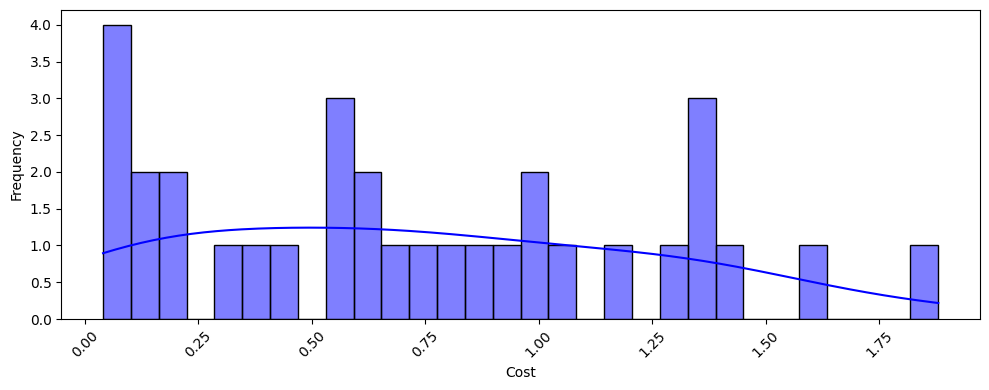

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_histograms(data):
        plt.figure(figsize=(10, 4))
        sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')
        plt.xlabel('Cost')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
data = recourse_without_rewards['Recourse Cost'].values

mean_recourse_cost = np.mean(data)
print("Mean of Recourse Cost:", mean_recourse_cost)

plot_histograms(data)

# Dice and other Explainer

In [ ]:
# Generate explanations using DICE
continuous_features = ['A2', 'A14']
explainer = get_explainer('dice', model=model, data=data_instance.data,
                          continuous_features=continuous_features,
                          outcome_name='A15')
query_instance = trainer.X_test.iloc[0:5]  # Selecting the first test instance
counterfactuals = explainer.generate_explanation(query_instance, total_CFs=5)

# Automatic Numerical Columns Finding from real dataset

In [ ]:
import sys  
sys.path.insert(1, '/Users/asifahmed/Documents/Codes/MyRecourseProject')

import pandas as pd
import itertools
from models.model_trainer import ModelTrainer
from data_handling.dataset import Dataset
from evaluation.evaluator import Evaluator

def is_numerical(data, column, target_column, threshold=20):
    """
    Consider a column numerical if it's not the target and has more than `threshold` unique values.
    """
    return data[column].nunique() > threshold and column != target_column

def automated_evaluation(file_path, target_column, model_type='svm', threshold=0.6, sample_size=300):
    # Initialize the model trainer
    trainer = ModelTrainer()

    dataset_name = file_path.split("/")[-1]
     # Initialize results list
    passed_pairs = []

    # Get all truly numerical columns from the original data
    original_data_instance = Dataset(target_column=target_column)
    original_data_instance.load_csv(file_path=file_path)
    original_data_instance.encode_categorical_columns()
    # original_data_instance.remove_outliers()
    original_data_instance.balanced_sample(sample_size)

    numerical_columns = [col for col in original_data_instance.data.columns if is_numerical(original_data_instance.data, col, target_column)]

    # Iterate over all pairs of numerical features
    for feature1, feature2 in itertools.combinations(numerical_columns, 2):
        # Reload data instance for each pair
        data_instance = Dataset(target_column=target_column)
        data_instance.load_csv(file_path)
        data_instance.encode_categorical_columns()
        # data_instance.remove_outliers()
        data_instance.balanced_sample(sample_size)

        # Select features and ensure they are present in the dataset
        data_instance.select_features([feature1, feature2, target_column])
        
        # if data_instance.data.empty:
        #     continue
        
        # Split and scale the data
        X_train, X_test, y_train, y_test = trainer.split_data(data_instance.data, target_column=target_column)

        if X_train.empty or X_test.empty:
            continue

        X_train_scaled, X_test_scaled = trainer.scale_features(X_train, X_test)
        
        # Train the model
        model = trainer.train(model_type, X_train_scaled, y_train)
        
        # Create an evaluator with the trained model and test data
        evaluator = Evaluator(model, X_test_scaled, y_test)
        
        # Obtain metrics using the Evaluator methods
        metrics = evaluator.get_evaluation_metrics()

        # Print necessary information if the threshold is met
        if metrics['Accuracy'] and metrics['Accuracy'] >= threshold:
            print(f"\033[1;32mPassed: {feature1}, {feature2} with accuracy {metrics['Accuracy']:.2f}\033[0m")
            evaluator.report()
            passed_pairs.append({
                'Dataset': dataset_name,
                'Feature1': feature1, 
                'Feature2': feature2,
                'Accuracy': metrics['Accuracy'],
                'Precision': metrics['Precision'], 
                'Recall': metrics['Recall'], 
                'F1 Score': metrics['F1 Score'],
                'Confusion Matrix': metrics['Confusion Matrix'].tolist(),
                'Classification Report': metrics['Classification Report']

                
            })
        else:
            # Print necessary information for all pairs
            print(f"Failed: {feature1}, {feature2} with accuracy {metrics['Accuracy']:.2f}")

        # Add space between iterations for readability
        print("\n" + "-" * 50 + "\n")

# Save passed pairs information to a text file]
    print("Saving passed pairs information to 'evaluation_results.txt'...")
    with open('evaluation_results.txt', 'w') as file:
        for pair in passed_pairs:
            file.write(f"Dataset: {pair['Dataset']}\n")
            file.write(f"Features: {pair['Feature1']}, {pair['Feature2']}\n")
            file.write(f"Accuracy: {pair['Accuracy']:.2f}\n")
            file.write(f"Precision: {pair['Precision']:.2f}\n")
            file.write(f"Recall: {pair['Recall']:.2f}\n")
            file.write(f"F1 Score: {pair['F1 Score']:.2f}\n")
            file.write(f"Confusion Matrix: {pair['Confusion Matrix']}\n")
            file.write("Classification Report:\n")
            file.write(f"{pair['Classification Report']}\n")
            file.write("-" * 50 + "\n")

automated_evaluation('/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/processed/credit_processed.csv', 
                     target_column='NoDefaultNextMonth',
                     threshold=.65,
                     sample_size=1000)

# Synthetic Data Generation

In [32]:
# Synthetic Data Generation Code

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency

def generate_synthetic_data(n_samples=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    genders = np.random.choice([1, 2], size=n_samples, p=[0.6, 0.4])
    
    X1 = np.zeros(n_samples)
    X2 = np.zeros(n_samples)
    
    for i in range(n_samples):
        if genders[i] == 1:
            # X1[i] = np.random.normal(55, 10)
            X1[i] = np.random.uniform(40, 70)
            X2[i] = np.random.normal(65, 15)
        else:
            # X1[i] = np.random.normal(45, 12)
            X1[i] = np.random.uniform(30, 60)
            X2[i] = np.random.normal(55, 15)
    

    X1 = np.round(X1).astype(int)
    X2 = np.round(X2).astype(int)

    noise = np.where(genders == 1, 
                     np.random.normal(0, 5, n_samples),
                     np.random.normal(0, 15, n_samples))
    noise = np.round(noise).astype(int)

    gender_effect = np.where(genders == 1, .1, -.08)
    
    decision_boundary = 0.5 * X1 + 0.3 * X2 + 0.2 * gender_effect + noise
    
    y = (decision_boundary > np.median(decision_boundary)).astype(int)

    # y = np.array([1 if (decision_boundary[i] + (5 if genders[i] == 2 else 0)) 
    #               > np.median(decision_boundary)
    #               else 0 for i in range(n_samples)])
    
    df = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'Gender': genders,
        'y': y
    })
    
    # print(df.sample(10))
    
    return df

# def perform_chi_square_tests(data):
#     data['Gender'] = pd.get_dummies(data['Gender'], drop_first=True)
    
#     for column in data.columns:
#         if column != 'y':
#             # Create a contingency table
#             contingency_table = pd.crosstab(data[column], data['y'])
#             chi2, p, dof, expected = chi2_contingency(contingency_table)
#             print(f"Chi-squared test for {column}:")
#             print(f"  Chi2 Statistic: {chi2:.2f}, P-value: {p:.3f}\n")

data = generate_synthetic_data(n_samples=5000)

X = data[['X1', 'X2', 'Gender']]
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

data.to_csv('synthetic_data_with_bias_and_uniform_x1.csv', index=False)
print("Synthetic data with bias generated and saved to 'synthetic_data_with_bias.csv'.")

Accuracy: 0.75
Synthetic data with bias generated and saved to 'synthetic_data_with_bias.csv'.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random

def sample_from_distribution(distribution_name, params, size=1):
    if distribution_name == 'normal':
        return np.random.normal(*params, size)
    elif distribution_name == 'uniform':
        return np.random.uniform(*params, size)
    elif distribution_name == 'power_law':
        shape, scale = params
        return (np.random.pareto(shape, size) + 1) * scale
    else:
        raise ValueError("Unsupported distribution type")

def generate_synthetic_data(n_samples=1000, seed=None, distributions=None, gender_proportions=None):
    if seed is not None:
        np.random.seed(seed)

    if gender_proportions is None:
        gender_proportions = [0.5, 0.5]  # Default to equal proportions if not specified

    genders = np.random.choice([1, 2], size=n_samples, p=gender_proportions)

    if distributions is None:
        raise ValueError("Distributions must be specified")

    X1, X2 = [], []
    for gender in genders:
        dists_X1 = distributions[gender]['X1']
        dists_X2 = distributions[gender]['X2']

        # Apply all distributions for X1
        X1_values = [sample_from_distribution(dist[0], dist[1], 1)[0] for dist in dists_X1]
        X1.append(np.mean(X1_values))  # Use the mean of all distribution samples for X1

        # Assuming only one distribution for X2 for simplicity, pick randomly
        X2_values = [sample_from_distribution(dist[0], dist[1], 1)[0] for dist in dists_X2]
        X2.append(np.mean(X2_values))  # Use the mean of all distribution samples for X2

    X1 = np.round(X1).astype(int)
    X2 = np.round(X2).astype(int)

    # Simplified decision boundary for demonstration, this can be more complex
    noise = np.random.normal(0, 10, n_samples)
    decision_boundary = 0.5 * X1 + 0.3 * X2 + noise
    y = (decision_boundary > np.median(decision_boundary)).astype(int)

    return pd.DataFrame({'X1': X1, 'X2': X2, 'Gender': genders, 'y': y})

distributions = {
    1: {'X1': [('uniform', (40, 70)), ('normal', (55, 10))], 'X2': [('normal', (65, 15))]},  # Male distributions
    2: {'X1': [('uniform', (30, 60)), ('power_law', (3, 45))], 'X2': [('normal', (55, 15))]}   # Female distributions
}
data = generate_synthetic_data(1000, distributions=distributions, gender_proportions=[0.6, 0.4])
print(data.head())

X = data[['X1', 'X2', 'Gender']]
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

data.to_csv('synthetic_data_with_custom_distributions.csv', index=False)
print("Synthetic data generated and saved to 'synthetic_data_with_custom_distributions.csv'.")

   X1  X2  Gender  y
0  43  57       2  0
1  52  40       1  0
2  42  59       1  1
3  60  61       1  1
4  51  52       1  0
Accuracy: 0.69
Synthetic data generated and saved to 'synthetic_data_with_custom_distributions.csv'.


# Miscellaneous

In [ ]:
model2 = trainer.train('svm', X_train_scaled, y_train)

evaluator2 = Evaluator(model2, X_test_scaled, y_test)
evaluator2.report()

gender_test = sensitive_features[X_test.index]
y_pred = model2.predict(X_test_scaled)
false_negatives = (y_test == 1) & (y_pred == 0)
false_negative_counts = gender_test[false_negatives].value_counts()
print("False Negative Counts by Gender:")
print(false_negative_counts)

misclassified = (y_test) != (y_pred)
sensitive_features_test = sensitive_features.loc[X_test.index]
X_misclassified = X_test_scaled[misclassified]  
y_misclassified = y_test[misclassified]  
gender_misclassified = sensitive_features_test[misclassified]

visualizer2 = Visualizer(model2, X_misclassified, y_misclassified, 
                        X_original=X_test[misclassified],
                        sensitive_attr=gender_misclassified)
visualizer2.plot_decision_boundary_interactive(('X1', 'X2'), 'SVM Plot')

In [ ]:
model3 = trainer.train('naive_bayes', X_train_scaled, y_train)

evaluator3 = Evaluator(model3, X_test_scaled, y_test)
evaluator3.report()

gender_test = sensitive_features[X_test.index]
y_pred = model3.predict(X_test_scaled)
false_negatives = (y_test == 1) & (y_pred == 0)
false_negative_counts = gender_test[false_negatives].value_counts()
print("False Negative Counts by Gender:")
print(false_negative_counts)

misclassified = (y_test) != (y_pred)
sensitive_features_test = sensitive_features.loc[X_test.index]
X_misclassified = X_test_scaled[misclassified]  
y_misclassified = y_test[misclassified]  
gender_misclassified = sensitive_features_test[misclassified]

visualizer3 = Visualizer(model3, X_misclassified, y_misclassified, 
                        X_original=X_test[misclassified],
                        sensitive_attr=gender_misclassified)
visualizer3.plot_decision_boundary_interactive(('X1', 'X2'), 'Naive Bayes Plot')